In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import os
import cv2

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

In [3]:
PATH = '../content/gdrive/MyDrive/colab_notebooks/mask_detection/'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 600 files belonging to 2 classes.


In [4]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 306 files belonging to 2 classes.


In [5]:
print(validation_dataset)
img_path = '../content/gdrive/MyDrive/colab_notebooks/mask_detection/test/mask/2070.jpg'
img_test = load_img(img_path)
print(img_test.format)

<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>
JPEG


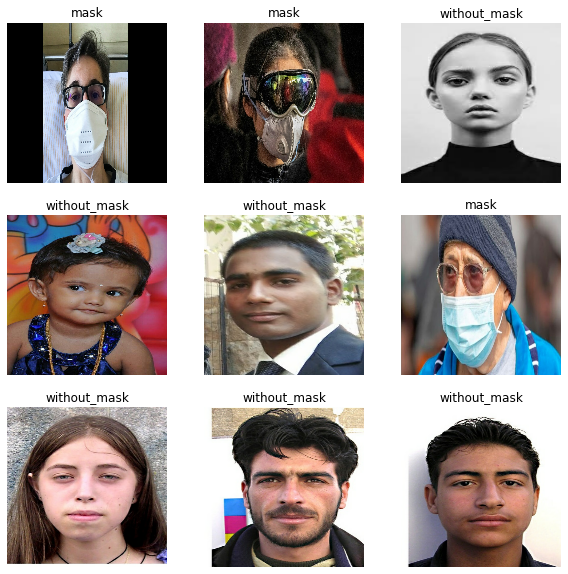

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 8
Number of test batches: 2


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

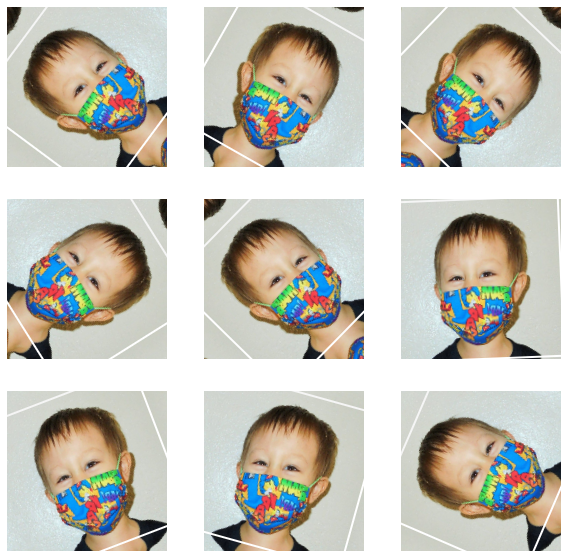

In [11]:
for image, _ in test_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

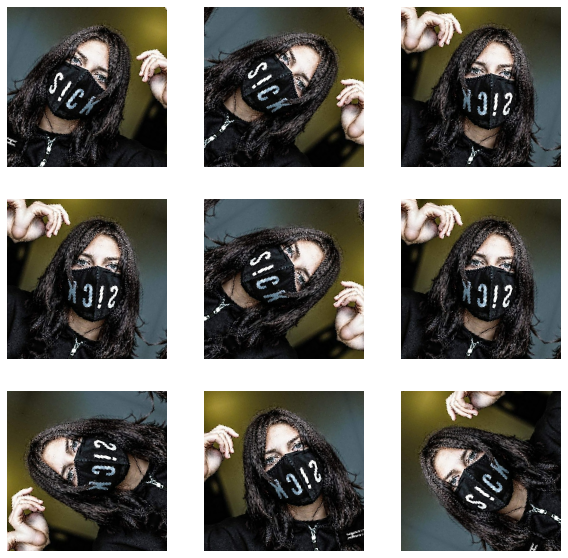

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [17]:
base_model.trainable = False

In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [24]:
len(model.trainable_variables)

2

In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

8/8 [==============================] - 5s 62ms/step - loss: 0.7963 - accuracy: 0.4342


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.79
initial accuracy: 0.45


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
19/19 [==============================] - 84s 4s/step - loss: 0.7811 - accuracy: 0.5333 - val_loss: 0.7078 - val_accuracy: 0.5165
Epoch 2/10
19/19 [==============================] - 6s 291ms/step - loss: 0.6806 - accuracy: 0.6117 - val_loss: 0.6431 - val_accuracy: 0.5496
Epoch 3/10
19/19 [==============================] - 7s 302ms/step - loss: 0.6285 - accuracy: 0.6417 - val_loss: 0.5809 - val_accuracy: 0.6281
Epoch 4/10
19/19 [==============================] - 7s 296ms/step - loss: 0.5929 - accuracy: 0.6733 - val_loss: 0.5240 - val_accuracy: 0.7231
Epoch 5/10
19/19 [==============================] - 7s 297ms/step - loss: 0.5698 - accuracy: 0.6883 - val_loss: 0.4967 - val_accuracy: 0.7025
Epoch 6/10
19/19 [==============================] - 7s 296ms/step - loss: 0.5015 - accuracy: 0.7383 - val_loss: 0.4735 - val_accuracy: 0.7397
Epoch 7/10
19/19 [==============================] - 7s 297ms/step - loss: 0.5035 - accuracy: 0.7317 - val_loss: 0.4354 - val_accuracy: 0.8058
Epoch 8/

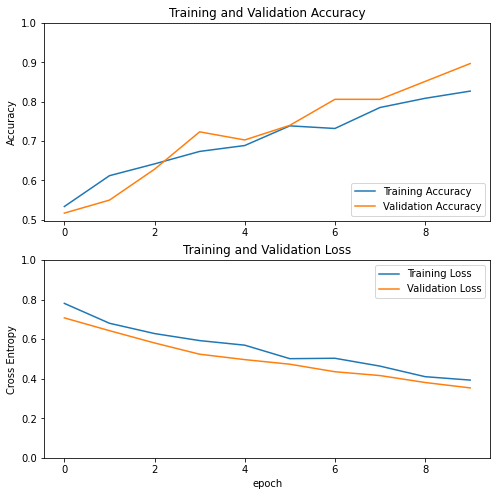

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [33]:
len(model.trainable_variables)

56

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
19/19 [==============================] - 12s 349ms/step - loss: 0.2550 - accuracy: 0.9120 - val_loss: 0.1082 - val_accuracy: 0.9959
Epoch 11/20
19/19 [==============================] - 7s 298ms/step - loss: 0.1219 - accuracy: 0.9685 - val_loss: 0.0802 - val_accuracy: 0.9959
Epoch 12/20
19/19 [==============================] - 7s 307ms/step - loss: 0.0854 - accuracy: 0.9703 - val_loss: 0.0499 - val_accuracy: 0.9917
Epoch 13/20
19/19 [==============================] - 7s 305ms/step - loss: 0.0704 - accuracy: 0.9748 - val_loss: 0.0525 - val_accuracy: 0.9917
Epoch 14/20
19/19 [==============================] - 7s 303ms/step - loss: 0.0515 - accuracy: 0.9835 - val_loss: 0.0342 - val_accuracy: 0.9917
Epoch 15/20
19/19 [==============================] - 7s 300ms/step - loss: 0.0477 - accuracy: 0.9828 - val_loss: 0.0220 - val_accuracy: 1.0000
Epoch 16/20
19/19 [==============================] - 7s 307ms/step - loss: 0.0334 - accuracy: 0.9881 - val_loss: 0.0167 - val_accuracy: 1.000

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

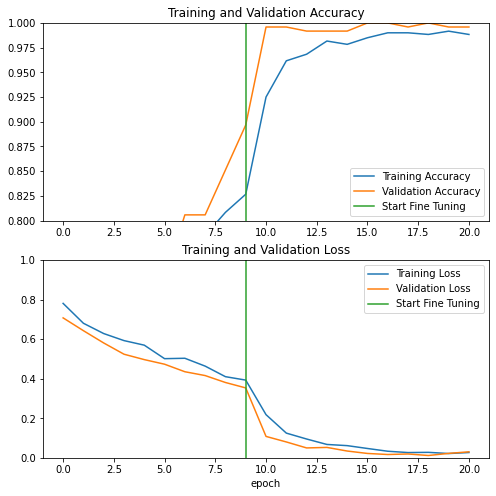

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 3s 285ms/step - loss: 0.0043 - accuracy: 1.0000
Test accuracy : 1.0


Predictions:
 [1 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0]
Labels:
 [1 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0]


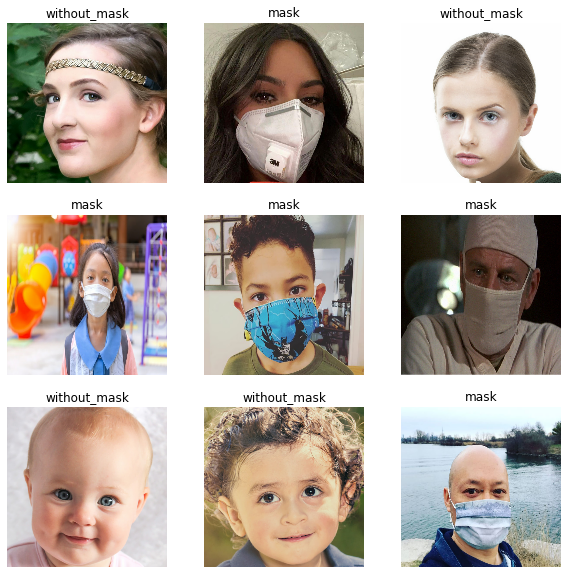

In [38]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

<Figure size 432x288 with 0 Axes>

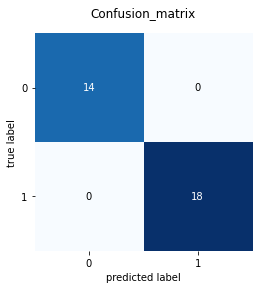

In [39]:
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

con=metrics.confusion_matrix(label_batch, predictions)
plt.figure()
fig, ax = plot_confusion_matrix(con, ['not masked', 'masked'])
title = plt.title('Confusion_matrix')
plt.show();

In [40]:
from sklearn.metrics import classification_report
print(classification_report(label_batch, predictions, target_names=class_names))

              precision    recall  f1-score   support

        mask       1.00      1.00      1.00        14
without_mask       1.00      1.00      1.00        18

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [41]:
from sklearn.metrics import roc_auc_score
from yellowbrick.classifier import ROCAUC
from tensorflow.keras.models import save_model, load_model

# auc scores
auc_score1 = roc_auc_score(label_batch, predictions)

print(auc_score1)

1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


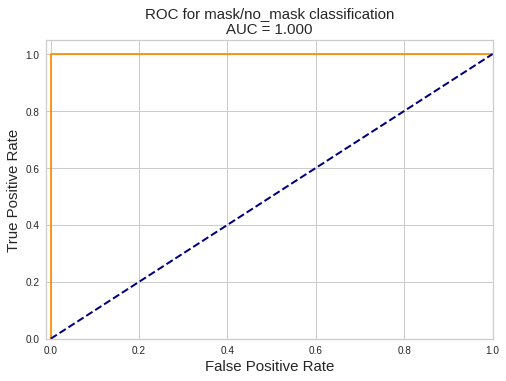

In [42]:
performance_plots_dir = Path('img')
performance_plots_dir.mkdir(exist_ok=True)

fpr, tpr, thr = metrics.roc_curve(label_batch, predictions)
auc = metrics.auc(fpr, tpr) 

plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title(f'ROC for mask/no_mask classification\nAUC = {auc:.3f}', size=15)
plt.savefig(performance_plots_dir / 'roc_classification.png', 
            bbox_inches='tight', pad_inches=0)

In [43]:
#from tensorflow.keras.models import save_model, load_model

In [44]:
#save_model(model, filepath='../content/gdrive/MyDrive/colab_notebooks/proyecto_final/model_test/mask_detector.h5')

In [45]:
#model = tf.keras.models.load_model('../content/gdrive/MyDrive/colab_notebooks/proyecto_final/model_test/model_1.h5')